In [2]:
import pandas as pd
import numpy as np
from scipy.stats import mode
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer as Imputer

csv_data=pd.read_csv(r'D:\A\data\2019_xyk.csv')
df1=csv_data.dropna(axis=1,how='all')   #删除全是空白值的数据

df2=df1.dropna(thresh=0.7*len(df1),axis=1)   #剔除空白值在70%以上的的列

df3=df2.fillna(df2.mean())    #按照每列的均值填充数据
loan=df3

loan['loan_status']=loan['loan_status'].replace(['Fully Paid','In Grace Period','Late (31-120 days)',
                                                 'Late (16-30 days)','Charged Off','Default','Current'],
                                               ['0','1','1','1','1','1','0'])
loan=loan[loan['loan_status'].isin(['0','1'])]
loan['loan_status']=loan['loan_status'].astype('int')

loan['grade']=loan['grade'].replace(['A','B','C','D','E','F','G'],['5','4','3','2','1','0.5','0'])
loan['emp_length']=loan['emp_length'].replace(['< 1 year','1 year','2 years','3 years','4 years','5 years',
                                               '6 years','7 years','8 years','9 years','10+ years'],
                                              ['0','1','2','3','4','5','6','7','8','9','10'])
loan['home_ownership']=loan['home_ownership'].replace(['RENT','MORTGAGE','OWN','ANY'],['3','2','1','0'])
loan['verification_status']=loan['verification_status'].replace(['Source Verified','Verified','Not Verified'],['3','2','1'])
loan['term']=loan['term'].replace(['36 months','60 months'],['1','2'])
oan=loan.drop(['issue_d'],axis=1)
loan.iloc[0]
loan=loan.drop(['purpose'],axis=1)
loan=loan.drop(['addr_state'],axis=1)
loan=loan.drop(['earliest_cr_line'],axis=1)
loan['revol_util'] = loan['revol_util'].str.strip("%").astype(float)/100
loan['int_rate'] = loan['int_rate'].str.strip("%").astype(float)/100
loan=loan.drop(['application_type'],axis=1)
loan['term']=loan['term'].replace([' 36 months',' 60 months'],['1','2'])

loan['sub_grade']=loan['sub_grade'].replace(['A1','A2','A3','A4','A5','B1','B2','B3','B4','B5','C1','C2','C3','C4','C5',
                                            'D1','D2','D3','D4','D5','E1','E2','E3','E4','E5','F1','F2','F3','F4','F5','G1','G2',
                                            'G3','G4','G5'],['7','6.8','6.6','6.4','6.2','6','5.8','5.6','5.4','5.2','5','4.8','4.6','4.4','4.2',
                                            '4','3.8','3.6','3.4','3.2','3','2.8','2.6','2.4','2.2','2','1.8','1.6','1.4','1.2','1','0.8',
                                            '0.6','0.4','0.2'])
loan=loan.drop(['emp_title'],axis=1)
loan=loan.drop(['grade'],axis=1)
loan=loan.drop(['issue_d'],axis=1)
loan=loan.drop(['title'],axis=1)
loan['pymnt_plan']=loan['pymnt_plan'].replace(['n','y'],['1','2'])
loan=loan.drop(['zip_code'],axis=1)
#loan=loan.drop(['next_pymnt_d'],axis=1)
loan['initial_list_status']=loan['initial_list_status'].replace(['f','w'],['1','2'])
loan=loan.drop(['last_pymnt_d'],axis=1)
loan=loan.drop(['last_credit_pull_d'],axis=1)
loan['hardship_flag']=loan['hardship_flag'].replace(['N','Y'],['1','2'])
loan['disbursement_method']=loan['disbursement_method'].replace(['Cash','DirectPay'],['1','2'])
loan['debt_settlement_flag']=loan['debt_settlement_flag'].replace(['N','Y'],['1','2'])
loan=loan.fillna(loan.mode())    #以中位数数填充

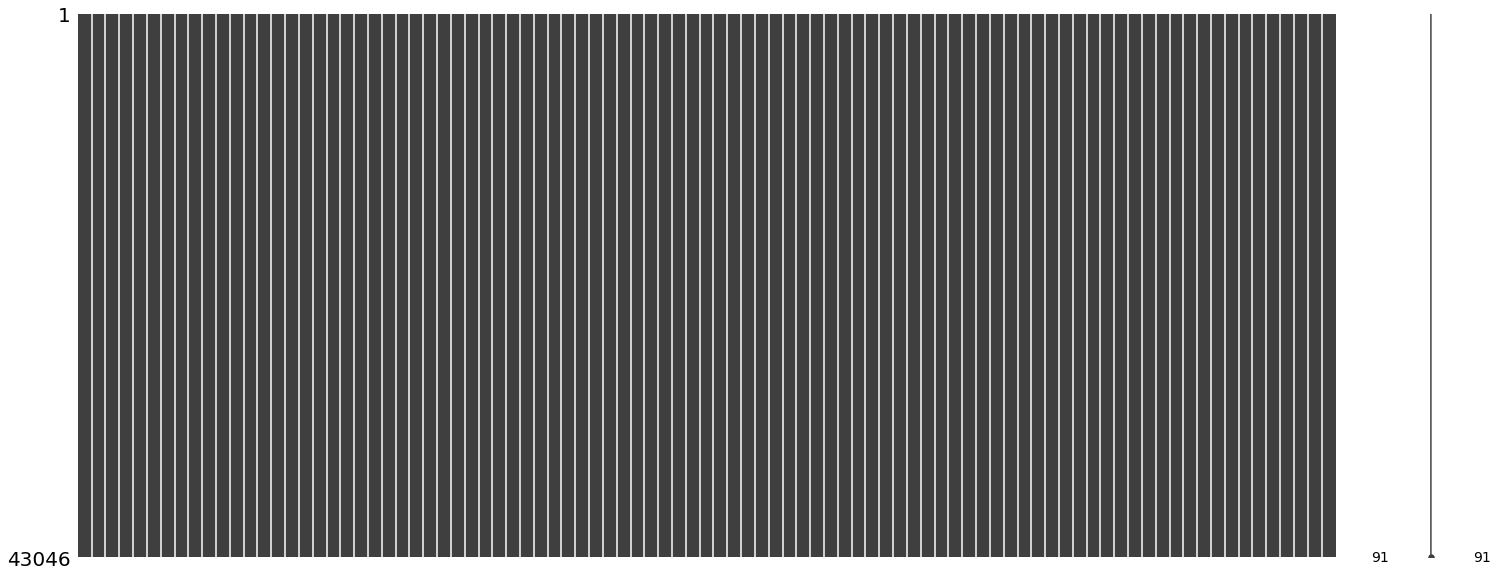

In [3]:
loan=loan.fillna(10)    ##不知道为啥我在用众数填充时，emp_length这一特征总是填不上，所以这个需要你自己先去看看这一列的众数是多少，
                        #然后把10改成你的众数就好

import missingno as msno
msno.matrix(loan) #这是一个查找空白值的程序，如果程序出来的结果都是一条条黑色的条，那就没问题，如果黑色的条纹中，有白色的横杠，那就是说有空白值
                  #这个需要你先安装missingno的程序包，不想用直接把这两行删掉

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc
from imblearn.over_sampling import SMOTE

loan=loan.drop(["annual_inc", "delinq_2yrs", "revol_bal", "total_acc", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d", "policy_code"],axis=1)
loan_1=loan.copy()


data_1=loan_1[loan_1['loan_status'] == 1]
data_0=loan_1[loan_1['loan_status'] == 0]

data_1_train,data_1_test=train_test_split(data_1,test_size=.3,random_state=12)
data_0_train,data_0_test=train_test_split(data_0,test_size=.3,random_state=12)
train=pd.concat([data_1_train,data_0_train])
test=pd.concat([data_1_test,data_0_test])

train_X=train.drop(['loan_status'],axis=1)
train_y=train['loan_status']
test_X=test.drop(['loan_status'],axis=1)
test_y=test['loan_status']

#resampled_X,resampled_y=SMOTE(random_state=12).fit_sample(train_X,train_y)
rf=RandomForestClassifier(n_estimators=500,max_depth=10,random_state=1).fit(train_X,train_y)
importance=pd.DataFrame({'features':train_X.columns.values,'importance':rf.feature_importances_})
importance.sort_values(by='importance',ascending=False).style.bar()
loan=loan.drop(importance[importance['importance'] < 0.0015]['features'].values,axis=1)#此处的0.0015随你，改成多少都没问题，不过这
                                                                                       #里尽可能小吧，毕竟还要在这里面做相关性，太大了特征太少

In [8]:
importance.sort_values(by='importance',ascending=False).style.bar()  #这是重要性的图

,features,importance
21,total_rec_prncp,0.178503
24,recoveries,0.171299
20,total_pymnt_inv,0.0833064
19,total_pymnt,0.0819544
23,total_rec_late_fee,0.0583859
17,out_prncp,0.0471445
18,out_prncp_inv,0.045001
5,installment,0.0346015
2,funded_amnt_inv,0.0256494
1,funded_amnt,0.0246536


['dti', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'tot_coll_amt', 'mths_since_rcnt_il', 'total_cu_tl', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'total_bc_limit', 'total_il_high_credit_limit']
['term', 'sub_grade', 'verification_status', 'pymnt_plan', 'hardship_flag', 'debt_settlement_flag']


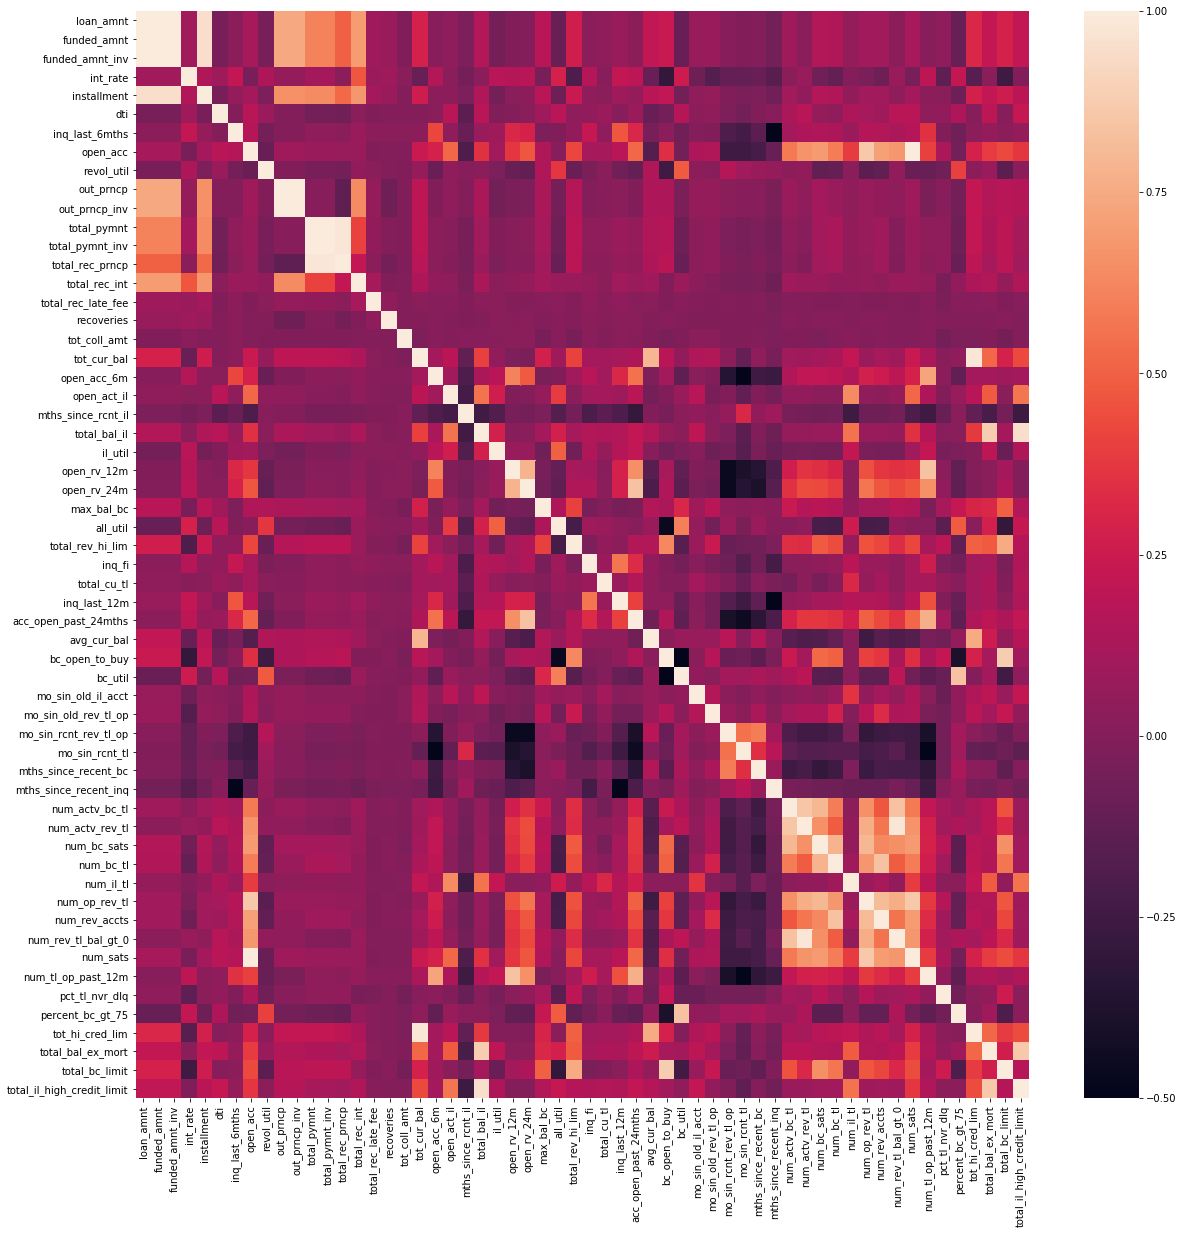

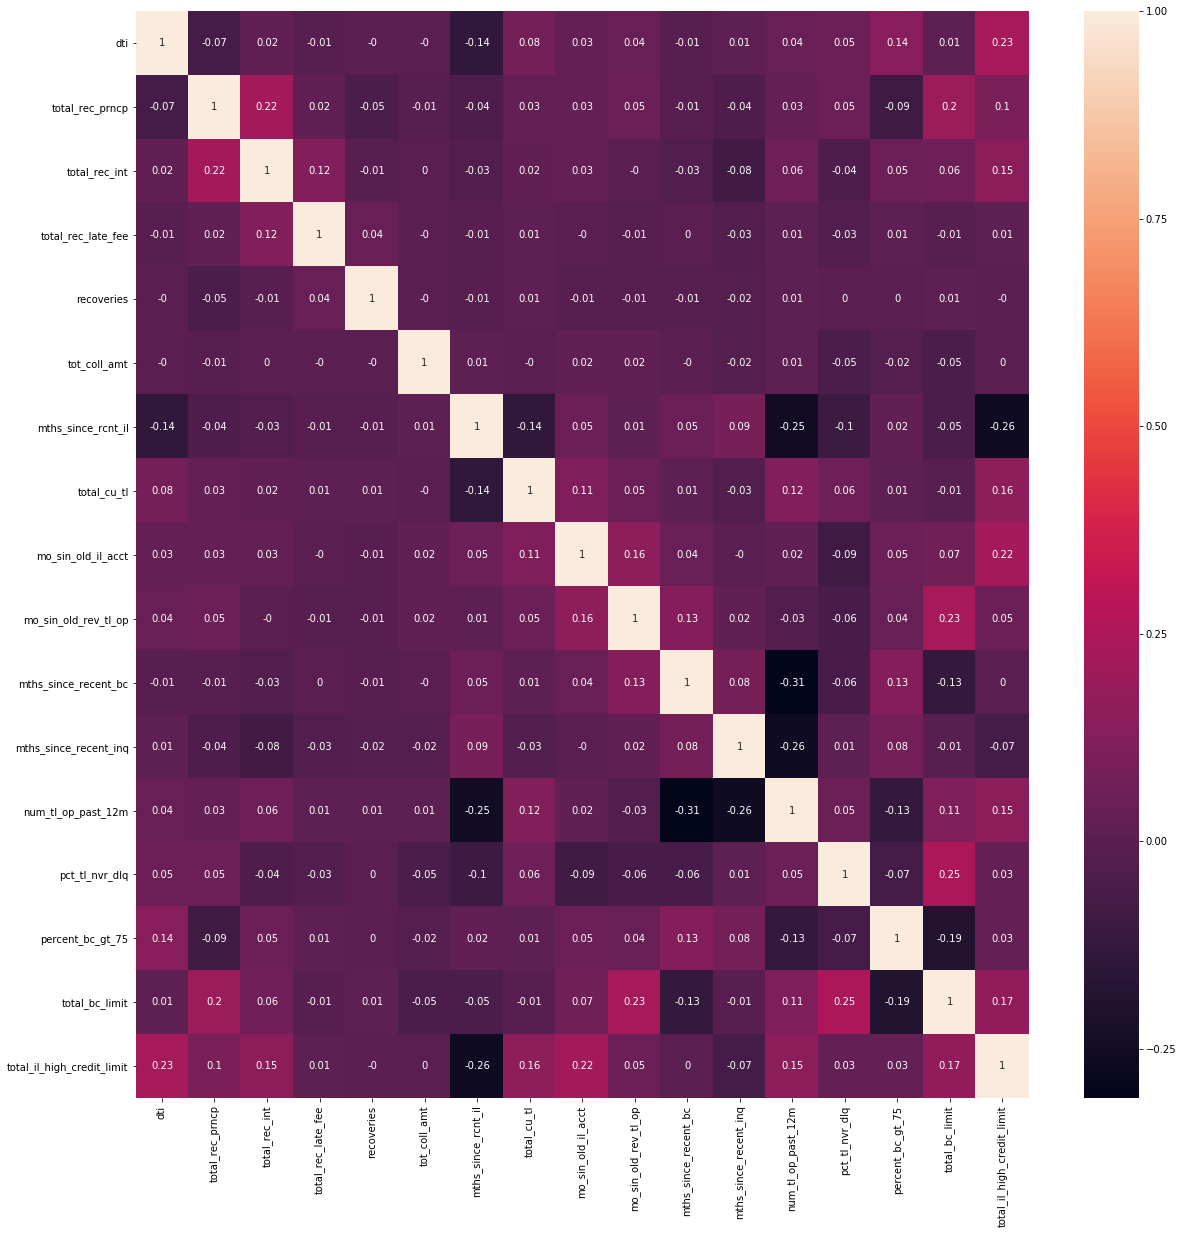

In [9]:
num_features=[]
obj_features=[]
for i in loan.columns.values:
    if loan[i].dtype == 'object':
        obj_features.append(i)
    else:
        num_features.append(i)
num_features.remove('loan_status')

fig,ax=plt.subplots(figsize=(20,20))
sns.heatmap(loan[num_features].corr().round(2))


cor=(np.abs(loan[num_features].corr()) < 0.4)  #这里的0.4是相关性阈值，随你选择，数值越大特征越多
l=[]
for i in range(len(num_features)):
    s=(cor.iloc[i+1:,i].sum() == (len(num_features)-i-1))
    l.append(s)
    
num_feats=[]
for i in range(len(num_features)):
    if l[i]:
        num_feats.append(num_features[i])
        
fig,ax=plt.subplots(figsize=(20,20))
sns.heatmap(loan[num_feats].corr().round(2),annot=True)
print(num_feats)   #这是做完相关性后的数据型特征
print(obj_features)#这是文本型特征

In [13]:
def value2group(x, cutoffs):
    cutoffs = sorted(cutoffs)
    num_groups = len(cutoffs)
    if x < cutoffs[0]:
        return 'group1'
    
    for i in range(1, num_groups):
        if cutoffs[i-1] <= x < cutoffs[i]:
            return 'group{}'.format(i)
    
    return 'group{}'.format(num_groups)

def calWOE(df, var, target):
    eps = 0.000001
    gbi = pd.crosstab(df[var], df[target]) + eps
    gb = df[target].value_counts() + eps
    gbri = gbi/gb
    gbri['woe'] = np.log(gbri[1] / gbri[0])
    return gbri['woe'].to_dict()

def calIV(df, var, target):
    eps = 0.000001
    gbi = pd.crosstab(df[var], df[target]) + eps
    gb = df[target].value_counts() + eps
    gbri = gbi/gb
    gbri['woe'] = np.log(gbri[1] / gbri[0])
    gbri['iv'] = (gbri[1] - gbri[0]) * gbri['woe']
    return gbri['iv'].sum()

def value2WOE(x, cutoffs, woe_map):
    cutoffs = sorted(cutoffs)
    num_groups = len(cutoffs)
    
    group = None
    
    if x < cutoffs[0]:
        group = 'group1'
    
    for i in range(1, num_groups):
        if cutoffs[i - 1] <= x < cutoffs[i]:
            group = 'group{}'.format(i)
            break
    
    if group is None:
        group = 'group{}'.format(num_groups)
    
    if group in woe_map:
        return woe_map[group]
    
    return None

In [15]:
num_features=[]
obj_features=[]
for i in loan.columns.values:
    if loan[i].dtype == 'object':
        obj_features.append(i)
    else:
        num_features.append(i)
num_features.remove('loan_status')
num_features

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'int_rate',
 'installment',
 'dti',
 'inq_last_6mths',
 'open_acc',
 'revol_util',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_op_past_12m',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'tot_hi_cred_lim',
 'total_bal_ex_mort',
 't

In [16]:
ivs = []
for item in num_features:
    value = calIV(loan, item, 'loan_status')
    ivs.append(value)
IV=pd.DataFrame({'feature':num_features,'IV':ivs})
IV.sort_values(by='IV',ascending=False).style.bar()

,feature,IV
13,total_rec_prncp,26.8647
18,tot_cur_bal,26.1382
12,total_pymnt_inv,25.9781
11,total_pymnt,25.9446
14,total_rec_int,24.9592
54,tot_hi_cred_lim,24.7952
55,total_bal_ex_mort,23.4206
22,total_bal_il,20.1047
57,total_il_high_credit_limit,19.2215
33,avg_cur_bal,18.2145
